#### Import thư viện

In [1]:
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import seaborn as sb
import pickle
import os
import time
from scipy.sparse import csr_matrix as spare_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import sparse
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#### Giới thiệu

Trong phần này, ta sẽ giải bài toán phân loại văn bản (text classification) bằng các phương pháp của Machine Learning.

Đầu tiên, ta sử dụng phương pháp Bag-of-Words (BoW) kết hợp với TF-IDF để trích chọn đặc trưng văn bản (feature extractor).

Sau đó, ta sẽ sử dụng các phương pháp phân loại sau:
- KNN
- Multinomial Naive Bayes
- Logistic Regression
- Random Forest
- SVM

#### Load dữ liệu
Đầu tiền, cần lấy dữ liệu đã tiền xử lý

In [2]:
# Đường dẫn
train_x_path = 'Data/saved/train_x.sav'
train_y_path = 'Data/saved/train_y.sav'
test_x_path = 'Data/saved/test_x.sav'
test_y_path = 'Data/saved/test_y.sav'

In [3]:
# Load dữ liệu
x_train = np.array(pickle.load(open(train_x_path, 'rb')))
y_train = np.array(pickle.load(open(train_y_path, 'rb')))
x_test = np.array(pickle.load(open(test_x_path, 'rb')))
y_test = np.array(pickle.load(open(test_y_path, 'rb')))

In [25]:
# load nhãn văn bản
labels = os.listdir('Data/train')
print('Số lượng nhãn:', len(labels))
labels

Số lượng nhãn: 27


['Am nhac',
 'Am thuc',
 'Bat dong san',
 'Bong da',
 'Chung khoan',
 'Cum ga',
 'Cuoc song do day',
 'Du hoc',
 'Du lich',
 'Duong vao WTO',
 'Gia dinh',
 'Giai tri tin hoc',
 'Giao duc',
 'Gioi tinh',
 'Hackers va Virus',
 'Hinh su',
 'Khong gian song',
 'Kinh doanh quoc te',
 'Lam dep',
 'Loi song',
 'Mua sam',
 'My thuat',
 'San khau dien anh',
 'San pham tin hoc moi',
 'Tennis',
 'The gioi tre',
 'Thoi trang']

#### Chia tập train và valid

In [4]:
# Khởi tạo StratifiedKFold object cho tập train và tập valid
num_folds = 5
rstate = 1
spliter = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=rstate)

#### Chọn độ đo

Nhóm sẽ sử dụng độ chính xác và độ phức tạp để đánh giá mô hình. Độ chính xác sẽ dựa trên accuracy score và f1 score, còn độ phức tạp sẽ được xét trên 3 phương diện là kích thước mô hình, thời gian train và thời gian test.

#### Bộ trích chọn đặc trưng

Việc trích chọn đặc trưng là tiền đề quan trọng để có thể có được một mô hình tốt. Việc trích chọn phải đảm bảo trích chọn được những đặc trưng quan trọng trong việc giải bài toán.

Với yêu cầu phân loại topic của văn bản, thì do đặc trưng của từng chủ đề mà mỗi văn bản có tần số xuất hiện của các từ khác nhau.

Cách phân loại này cũng rất giống cách mà con người phân loại văn bản thông thường, đó là tìm những key word mà chứa nhiều thông tin về topic của văn bản đó. Vì vậy, cách trích chọn đặc trưng dựa trên tần số xuất hiện các từ trong văn bản là rất tự nhiêu và hiệu quả.

Phương pháp sử dụng: Bag of Words và TF-IDF. Bag of Words để chuyển văn bản về 1 vector tần số (vectorize) và TF-IDF là một phương pháp tính trọng số để tạo sự chuẩn hóa các giá trị trong vector BoW giữa văn bản dài và văn bản ngắn.

In [29]:
feature_extractor = Pipeline([
    # Chuyển tập dữ liệu sang dạng vector count dựa trên một vocab chung (BoW), loại bỏ những word có tần suất xuất hiện > 0.8
    ('vectorize', CountVectorizer(max_df=0.8, encoding='utf-16')),
    
    # Áp dụng TF-IDF để trích chọn đặc trưng (extract feature)
    ('feature extracter', TfidfTransformer())
])

train_features = feature_extractor.fit_transform(x_train, y_train)
pickle.dump(feature_extractor, open('Data/saved/feature_extractor.sav', 'wb'))
print('Kích thước vector input: ', train_features.shape[1])

Kích thước vector input:  79170


In [30]:
# sử dụng thư viện TSNE để convert vector 79170 chiều thành vector 2 chiều
# việc này sẽ giúp việc visualize thuận tiện hơn
tsne = TSNE(n_components=2, random_state=rstate)
train_x_2d = tsne.fit_transform(train_features)
print('Kích thước mới: ', train_x_2d.shape)

e:\AIWorkplace\VietnameseNewClassification\venv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
e:\AIWorkplace\VietnameseNewClassification\venv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Kích thước mới:  (14375, 2)


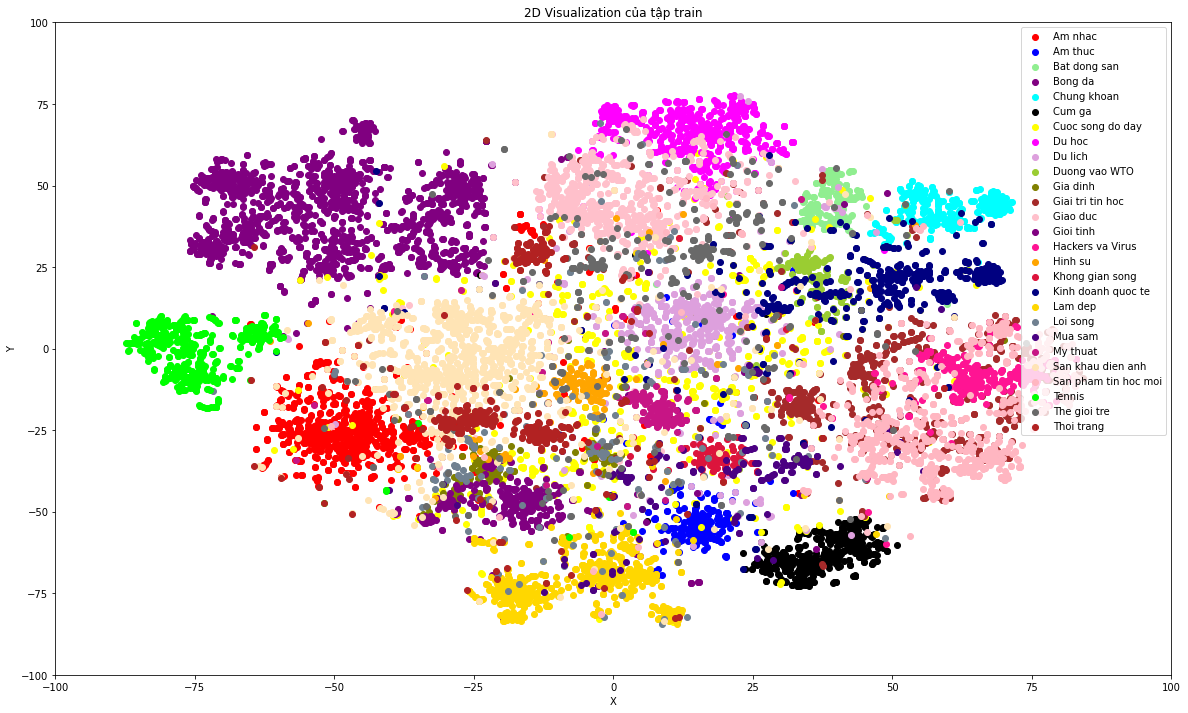

In [31]:
# scatter các điểm dữ liệu lên mặt phẳng 2 chiều
plt.figure(figsize=(20, 12))
color_map = {
    0: 'red', 1: 'blue', 2: 'lightgreen', 3: 'purple', 4: 'cyan', 5: 'black', 6: 'yellow', 7: 'magenta',
    8: 'plum', 9: 'yellowgreen', 10: 'olive', 11: 'brown', 12: 'pink', 13: 'purple', 14: 'deeppink',
    15: 'orange', 16: 'crimson', 17: 'navy', 18: 'gold', 19: 'greenyellow', 19: 'aquamarine', 19: 'slategrey',
    20: 'indigo', 21: 'mediumvioletred', 22: 'moccasin', 23: 'lightpink', 24: 'lime', 25: 'dimgrey', 26: 'firebrick'
}

for idx, label in enumerate(labels):
    plt.scatter(x=train_x_2d[y_train == label, 0], y=train_x_2d[y_train == label, 1], marker='o', c=color_map[idx], label=label)

plt.xlabel('X')
plt.ylabel('Y')
plt.axis([-100, 100, -100, 100])
plt.legend()
plt.title('2D Visualization của tập train')
plt.savefig('image/feature_extractor_visualization.png', facecolor='whitesmoke', bbox_inches='tight')
plt.show()

**Nhận xét:** Dựa trên hình thì việc extract feature bằng BoW + TF-IDF cũng đã là khá tốt khi dữ liệu được phân thành các cụm khá rõ rệt.

## Lựa chọn mô hình
Trong phần này, nhóm  sẽ tiền hành lựa chọn tham số tốt nhất cho từng mô hình sau và sau đó lựa chọn mô hình tốt nhất cho bài toán.
- KNN
- Naive Bayes Multinomial
- Logistic Regression
- Random forest
- SVM

#### 1. KNN

KNN có thể coi là phương pháp đơn giản nhất và thường được nghĩ đến đầu tiên trong các bài toán phân loại bởi vì sự đơn giản trong ý tưởng của nó. Trong phương pháp này sẽ có siêu tham số là K và loại khoảng cách mà thuật toán sử dụng.

Trong đó:

$$K \in \{1, 2, 5, 8, 10, 15, 20, 25, 30\}$$

Với khoảng cách, nhóm sẽ xét 2 loại khoảng cách là:
- Khoảng cách Manhattan (khoảng cách Minkowski với p = 1)

$$dist(x, y) = \sum_{i=0}^{n-1} (x[i] - y[i])$$

- Khoảng cách Euclid (khoảng cách Minkowski với p = 2)

$$dist(x, y) = \sqrt{\sum_{i=0}^{n-1} (x[i] - y[i])^2}$$

In [19]:
# cố định khoảng cách mặc định là euclid và thay đổi K (số hàng xóm)
k_list = [1, 2, 5, 8, 10, 15, 20, 25, 30]
mean_accuracy_scores = []
mean_f1_scores = []
mean_train_time = []
mean_valid_time = []
for k in k_list:
    # định nghĩa model
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # validate mô hình
    accs = []
    f1s = []
    train_times = []
    valid_times = []
    
    for train_index, valid_index in spliter.split(x_train, y_train):
        # train model
        start = time.time_ns()
        knn.fit(train_features[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)
        
        # valid model
        start = time.time_ns()
        y_pred = knn.predict(train_features[valid_index])
        valid_times.append(time.time_ns() - start)
        
        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
    mean_train_time.append(mean(train_times))
    mean_valid_time.append(mean(valid_times))
    mean_accuracy_scores.append(mean(accs))
    mean_f1_scores.append(mean(f1s))

    print(f'Với k = {k}:')
    print('\t- Thời gian train: {:.2f} ms'.format(mean_train_time[-1] / 1e6))
    print('\t- Thời gian valid: {:.2f} ms'.format(mean_valid_time[-1] / 1e6))
    print('\t- Accuracy score:  {:.3f} %'.format(mean_accuracy_scores[-1] * 100))
    print('\t- F1 score:        {:.3f} %'.format(mean_f1_scores[-1] * 100))

Với k = 1:
	- Thời gian train: 32.08 ms
	- Thời gian valid: 1508.03 ms
	- Accuracy score:  80.125 %
	- F1 score:        74.938 %
Với k = 2:
	- Thời gian train: 31.59 ms
	- Thời gian valid: 1801.85 ms
	- Accuracy score:  78.922 %
	- F1 score:        73.118 %
Với k = 5:
	- Thời gian train: 28.46 ms
	- Thời gian valid: 1893.56 ms
	- Accuracy score:  82.616 %
	- F1 score:        77.631 %
Với k = 8:
	- Thời gian train: 23.19 ms
	- Thời gian valid: 1548.68 ms
	- Accuracy score:  83.110 %
	- F1 score:        78.191 %
Với k = 10:
	- Thời gian train: 27.62 ms
	- Thời gian valid: 1770.67 ms
	- Accuracy score:  83.520 %
	- F1 score:        78.556 %
Với k = 15:
	- Thời gian train: 25.49 ms
	- Thời gian valid: 1641.17 ms
	- Accuracy score:  83.798 %
	- F1 score:        78.723 %
Với k = 20:
	- Thời gian train: 25.12 ms
	- Thời gian valid: 1713.90 ms
	- Accuracy score:  83.833 %
	- F1 score:        78.793 %
Với k = 25:
	- Thời gian train: 29.46 ms
	- Thời gian valid: 1859.66 ms
	- Accuracy score:  83

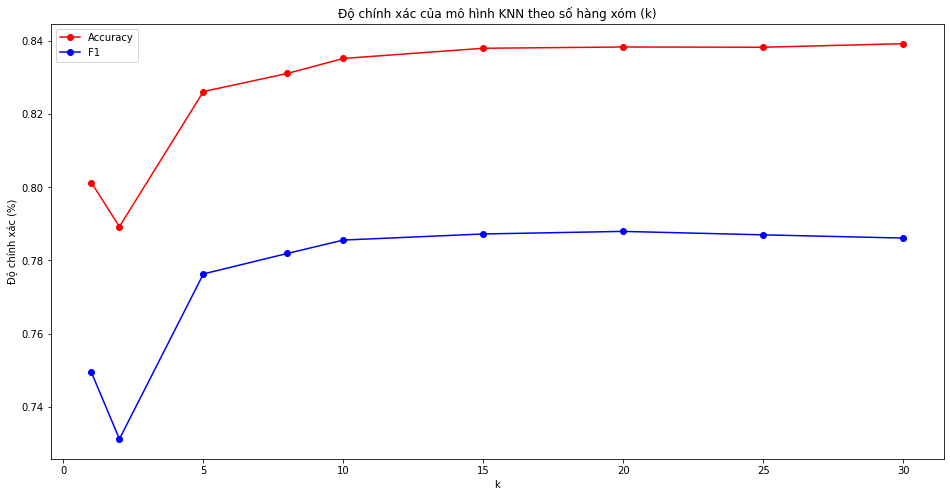

In [20]:
# plot accuracy
plt.figure(figsize=(16, 8))
plt.title('Độ chính xác của mô hình KNN theo số hàng xóm (k)')
plt.xlabel('k')
plt.ylabel('Độ chính xác (%)')
plt.plot(k_list, mean_accuracy_scores, 'ro-')
plt.plot(k_list, mean_f1_scores, 'bo-')
plt.legend(['Accuracy', 'F1'], loc='best')
plt.savefig('image/knn_accuracy.png', facecolor='whitesmoke')
plt.show()

**Kết luận:** Ta thấy với k = 20 cho kết quả tốt nhất f1 score trong khi k = 30 cho kết quả tốt nhất về accuracy score. Nhóm sẽ chọn k =30. Đặc biệt, thời gian train và valid cũng không thay đổi nhiều khi tăng k lên do bản chất của thuật toán KNN là một thuật toán 'lười' nên không cần xét tới thời gian khi chọn k.

In [23]:
# cố định k = 30, thay đổi khoảng cách
fixed_k = 30
distances = ['manhattan', 'euclidean']
mean_accuracy_scores = []
mean_f1_scores = []
mean_train_time = []
mean_valid_time = []
for dist in distances:
    # định nghĩa model
    knn = KNeighborsClassifier(n_neighbors=fixed_k, metric=dist)
    
    accs = []
    f1s = []
    train_times = []
    valid_times = []
    for train_index, valid_index in spliter.split(x_train, y_train):    
        # train model
        start = time.time_ns()
        knn.fit(train_features[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)
        
        # valid model
        start = time.time_ns()
        y_pred = knn.predict(train_features[valid_index])
        valid_times.append(time.time_ns() - start)
        
        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
    mean_train_time.append(mean(train_times))
    mean_valid_time.append(mean(valid_times))
    mean_accuracy_scores.append(mean(accs))
    mean_f1_scores.append(mean(f1s))
    
    print(f'Với distance = {dist}:')
    print('\t- Thời gian train: {:.2f} ms'.format(mean_train_time[-1] / 1e6))
    print('\t- Thời gian valid: {:.2f} ms'.format(mean_valid_time[-1] / 1e6))
    print('\t- Accuracy score:  {:.3f} %'.format(mean_accuracy_scores[-1] * 100))
    print('\t- F1 score:        {:.3f} %'.format(mean_f1_scores[-1] * 100))

Với distance = manhattan:
	- Thời gian train: 26.67 ms
	- Thời gian valid: 11360.57 ms
	- Accuracy score:  47.089 %
	- F1 score:        42.823 %
Với distance = euclidean:
	- Thời gian train: 24.78 ms
	- Thời gian valid: 1447.95 ms
	- Accuracy score:  83.924 %
	- F1 score:        78.611 %


**Nhận xét:** Khoảng cách Euclide cho kết quả tốt hơn hẳn và thời gian train và test cũng thấp hơn nhiều so với khoảng cách Manhattan.

*$\rightarrow$ **Kết luận:** Vậy tham số tốt nhất cho KNN là k = 30 và khoảng cách Euclide.*

#### 2. Multinomial Naive Bayes

Naive Bayes là một thuật toán phân lớp dựa trên định lý Bayes trong xác suất thông kê. Naive Bayes dựa trên 2 giả thuyết về dữ liệu đầu vào:
- Các đặc trưng của dữ liệu đầu vào là độc lập với nhau
- Các đặc trưng đầu vào có ảnh hưởng như nhau đối với đầu ra

Chính vì 2 giả thuyết này gần như không bao giờ tồn tại trong thực tế nên thuật toán này được coi là "ngây thơ". Tuy nhiên thuật toán này lại có tốc độ tính toán nhanh, dễ cài đặt và cũng hiệu quả trong 1 số trường hợp nhất định.

Multinomial Naive Bayes là loại thuật toán Naive Bayes hay được sử dụng với văn bản mà các vector được xây dựng dựa trên ý tưởng Bag-of-Words. Tuy nhiên với dữ liệu văn bản và bài toán phân loại chủ đề thì 2 giả thuyết của Naive Bayes là hoàn toàn không hợp lý. Bởi vì các từ trong một văn bản không hề độc lập với nhau và chúng cũng có ảnh hưởng khác nhau tới topic của văn bản. Vì vậy, mô hình này có thể sẽ cho kết quả không cao.

Siêu tham số mô hình: Trong mô hình Multinomial Naive Bayes có sử dụng kỹ thuật Laplace Smoothing để hạn chế trường hợp nếu 1 từ mới xuất hiện sẽ làm cho xác xuất tổng thể của một văn bản bằng 0 bất kể các từ phía sau xuất hiện nhiều thế nào. Hệ số làm mềm $\alpha$ là một số dương, khi $\alpha$ càng lớn thì các xác suất xuất hiện của các từ sẽ càng "mềm". Danh sách $\alpha$:

$$\alpha \in \{ 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 8, 10 \}$$

In [24]:
from sklearn.naive_bayes import MultinomialNB
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 8, 10]
mean_accuracy_scores = []
mean_f1_scores = []
mean_train_time = []
mean_valid_time = []
for a in alphas:
    # định nghĩa model
    model = MultinomialNB(alpha=a)
    
    accs = []
    f1s = []
    train_times = []
    valid_times = []

    for train_index, valid_index in spliter.split(x_train, y_train):    
        # train model
        start = time.time_ns()
        model.fit(train_features[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)
        
        # valid model
        start = time.time_ns()
        y_pred = model.predict(train_features[valid_index])
        valid_times.append(time.time_ns() - start)
        
        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
    mean_train_time.append(mean(train_times))
    mean_valid_time.append(mean(valid_times))
    mean_accuracy_scores.append(mean(accs))
    mean_f1_scores.append(mean(f1s))
    
    print(f'Với alpha = {a}:')
    print('\t - Thời gian train: {:.2f} ms'.format(mean_train_time[-1] / 1e6))
    print('\t - Thời gian valid: {:.2f} ms'.format(mean_valid_time[-1] / 1e6))
    print('\t - Accuracy score:  {:.2f} %'.format(mean_accuracy_scores[-1] * 100))
    print('\t - F1 score:        {:.2f} %'.format(mean_f1_scores[-1] * 100))

Với alpha = 0.001:
	 - Thời gian train: 235.65 ms
	 - Thời gian valid: 25.19 ms
	 - Accuracy score:  88.77 %
	 - F1 score:        86.03 %
Với alpha = 0.005:
	 - Thời gian train: 173.98 ms
	 - Thời gian valid: 15.95 ms
	 - Accuracy score:  89.11 %
	 - F1 score:        86.33 %
Với alpha = 0.01:
	 - Thời gian train: 181.68 ms
	 - Thời gian valid: 16.84 ms
	 - Accuracy score:  89.15 %
	 - F1 score:        86.20 %
Với alpha = 0.05:
	 - Thời gian train: 197.92 ms
	 - Thời gian valid: 18.55 ms
	 - Accuracy score:  86.24 %
	 - F1 score:        80.11 %
Với alpha = 0.1:
	 - Thời gian train: 206.55 ms
	 - Thời gian valid: 18.28 ms
	 - Accuracy score:  82.99 %
	 - F1 score:        71.94 %
Với alpha = 0.5:
	 - Thời gian train: 182.52 ms
	 - Thời gian valid: 16.26 ms
	 - Accuracy score:  75.83 %
	 - F1 score:        57.97 %
Với alpha = 1:
	 - Thời gian train: 189.96 ms
	 - Thời gian valid: 17.67 ms
	 - Accuracy score:  72.10 %
	 - F1 score:        53.62 %
Với alpha = 2:
	 - Thời gian train: 173.72 m

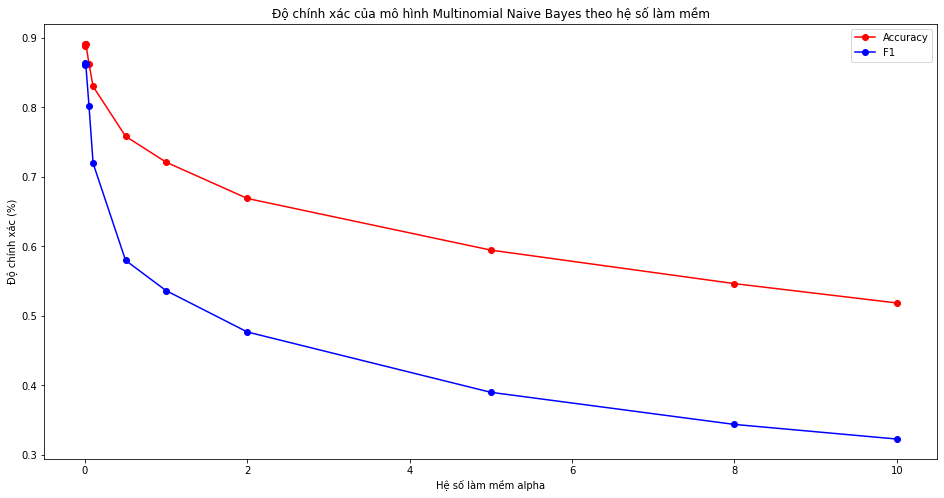

In [25]:
# plot accuracy
plt.figure(figsize=(16, 8))
plt.title('Độ chính xác của mô hình Multinomial Naive Bayes theo hệ số làm mềm')
plt.xlabel('Hệ số làm mềm alpha')
plt.ylabel('Độ chính xác (%)')
plt.plot(alphas, mean_accuracy_scores, 'ro-')
plt.plot(alphas, mean_f1_scores, 'bo-')
plt.legend(['Accuracy', 'F1'], loc='best')
plt.savefig('image/mnb_a_accuracy.png', facecolor='whitesmoke')
plt.show()

**Nhận xét:** Ta thấy, việc làm mềm quá ít hoặc quá nhiều đều sẽ làm giảm đáng kể độ chính xác của mô hình. Khi làm mềm quá ít thì các từ chưa từng xuất hiện trong tập dữ liệu sẽ ảnh hưởng nhiều tới xác xuất của nhãn trong khi làm mềm quá nhiều sẽ làm các từ có xác suất gần nhau hơn, giảm khả năng phân loại của mô hình.

*$\rightarrow$ **Kết luận:** Tham số tốt nhất cho Multinomial Naive Bayes là alpha = 0.005*

#### 3. Logistic Regression

Logistic Regression là một mô hình hồi quy để dự đoán các giá trị đầu ra rời rạc, nó tương tự như một mô hình phân loại. Logistic Regression sử dụng hàm sigmoid làm activation function để phân tách các miền giá trị.

Hàm sigmoid:

$$sigmoid(x) = \frac{1}{1 + e^{-x}}$$

Đồ thị hàm sigmoid:

![sigmoid_function](image/sigmoid_function.png)

Thông thường, ngưỡng quyết định của hàm sigmoid là 0.5 tức là nếu hơn 0.5 sẽ cho là nhãn 1 còn nhỏ hơn 0.5 sẽ là nhãn 0. Tuy nhiên với 1 số trường hợp trong thực tế, việc chọn ngưỡng có thể nghiêng về một bên. Ví dụ như phân loại giao dịch là hợp lệ hay không hợp lệ thì ngưỡng có thể gần hợp lệ hơn để tránh để lọt các giao dịch phi pháp. Trong bài toán này, để công bằng giữa các nhãn, nhóm vẫn chọn ngưỡng mặc định là 0.5.

Mô hình Logistic Regression có 3 siêu tham số cần chọn đó là phương pháp hiệu chỉnh, hệ số hiệu chỉnh và thuật toán tối ưu. Với mỗi thuật toán tối ưu sẽ hỗ trợ một số phương pháp hiệu chỉnh khác nhau. Trong đó:

Thuật toán tối ưu:
- Newton's method ('l2', 'none'): Thuật toán này cũng hướng tới việc xấp xỉ hàm loss bậc 2 tương tự như Gradient Descent, những khác ở chỗ nó sử dụng phép xấp xỉ bậc 2, tại mỗi bước nó sẽ xấp xỉ hàm số f(x) bằng 1 hàm số bậc 2 quanh x và tiến 1 bước về cực đại hoặc cực tiểu của hàm đó.
- Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm ('l2', 'none'): Tương tự như Newton's method nhưng ma trận Hessian được tính gần đúng bằng cách đánh giá đạo hàm. Phương pháp này rất tốt cho tập dữ liệu nhỏ.
- A Library for Large Linear Classification ('l1', 'l2'): Là một phương pháp linear classification mà hỗ trợ Logistic Regression và linear SVM
- Stochastic Average Gradient ('l2', 'none'): Phương pháp SAG thực hiện tối ưu hóa tổng của một số hữu hạn các hàm lồi trơn.
- SAGA ('elasticnet', 'l2', 'l1', 'none'): Là một biến thể của SAG nhưng hỗ trợ L1, nó hoạt động rất tốt với những bộ dữ liệu rất lớn.

Phương pháp hiệu chỉnh
- none: Không hiệu chỉnh
- l1: Hiệu chỉnh L1
- l2: Hiệu chỉnh L2
- elasticnet: Kết hợp giữa L1 và L2

Nghịch đảo của hệ số hiệu chỉnh (C) - C càng nhỏ, hiệu chỉnh càng mạnh:

$$C \in \{ 1, 2, 5, 10, 16 \}$$

Phương pháp này sử dụng TF-IDF cho phần trích chọn đặc trưng. Độ chính xác của Logistic Regression sẽ phụ thuộc phần lớn vào khả năng phân cụm của bộ trích chọn đặc trưng.

In [27]:
# cố định phương pháp hiệu chình là l2 và C = 2, thay đổi thuật toán tối ưu
from sklearn.linear_model import LogisticRegression
opts = {'newton-cg': ['l2', 'none'], 'lbfgs': ['l2', 'none'], 'liblinear': [
    'l1', 'l2'], 'sag': ['l2', 'none'], 'saga': ['elasticnet', 'l1', 'l2', 'none']}
fixed_C = 2
fixed_reg = 'l2'
MAX_ITER = 100_000

mean_accuracy_scores = []
mean_f1_scores = []
mean_train_time = []
mean_valid_time = []
for opt in opts.keys():
    print('Thuật toán tối ưu: ', opt)
    # định nghĩa model
    model = LogisticRegression(
        solver=opt, penalty=fixed_reg, C=2, max_iter=MAX_ITER)

    accs = []
    f1s = []
    train_times = []
    valid_times = []

    for train_index, valid_index in spliter.split(x_train, y_train):
        # train model
        start = time.time_ns()
        model.fit(train_features[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)

        # valid model
        start = time.time_ns()
        y_pred = model.predict(train_features[valid_index])
        valid_times.append(time.time_ns() - start)

        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))

    mean_accuracy_scores.append(mean(accs))
    mean_f1_scores.append(mean(f1s))
    mean_train_time.append(mean(train_times))
    mean_valid_time.append(mean(valid_times))

    print('\t- Thời gian train: {:.2f} ms'.format(mean_train_time[-1] / 1e6))
    print('\t- Thời gian valid: {:.2f} ms'.format(mean_valid_time[-1] / 1e6))
    print('\t- Accuracy score:  {:.3f} %'.format(mean_accuracy_scores[-1] * 100))
    print('\t- F1 score:        {:.3f} %'.format(mean_f1_scores[-1] * 100))

Thuật toán tối ưu:  newton-cg
	- Thời gian train: 60832.16 ms
	- Thời gian valid: 20.10 ms
	- Accuracy score:  90.922 %
	- F1 score:        87.950 %
Thuật toán tối ưu:  lbfgs
	- Thời gian train: 57515.92 ms
	- Thời gian valid: 18.21 ms
	- Accuracy score:  90.922 %
	- F1 score:        87.950 %
Thuật toán tối ưu:  liblinear
	- Thời gian train: 10172.61 ms
	- Thời gian valid: 10.93 ms
	- Accuracy score:  90.678 %
	- F1 score:        87.510 %
Thuật toán tối ưu:  sag
	- Thời gian train: 9796.55 ms
	- Thời gian valid: 19.06 ms
	- Accuracy score:  90.922 %
	- F1 score:        87.950 %
Thuật toán tối ưu:  saga
	- Thời gian train: 10408.04 ms
	- Thời gian valid: 18.02 ms
	- Accuracy score:  90.936 %
	- F1 score:        87.965 %


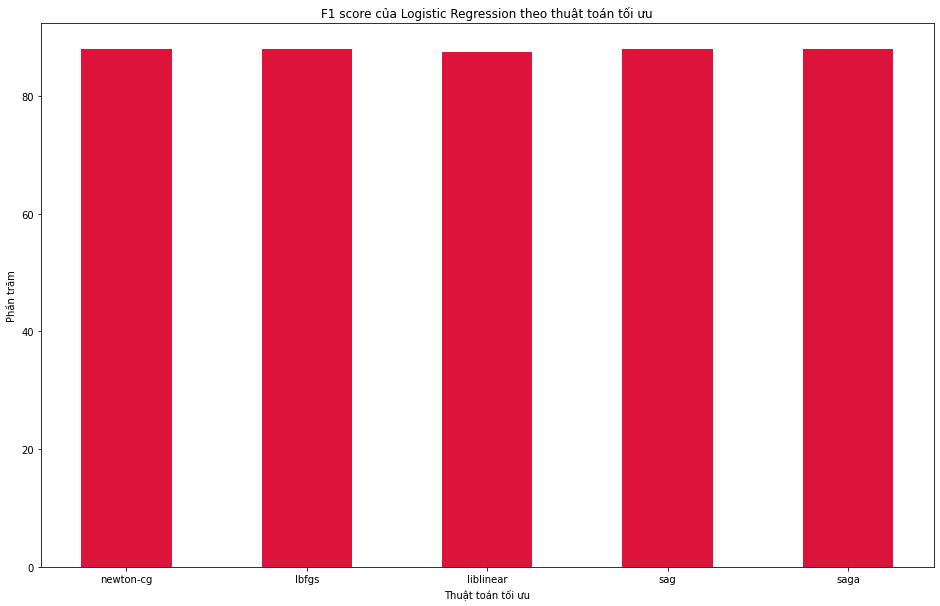

In [28]:
# Vẽ f1
plt.figure(figsize=(16, 10))
plt.title('F1 score của Logistic Regression theo thuật toán tối ưu')
plt.xlabel('Thuật toán tối ưu')
plt.ylabel('Phần trăm')
plt.bar(opts.keys(), np.array(mean_f1_scores) * 100, color='crimson', width=0.5, label='F1')
plt.savefig('image/lgres_opt_f1_comparision.png', facecolor='whitesmoke')
plt.show()

**Nhận xét:** Trong số 5 thuật toán tối ưu thì thuật toán SAGA là cho độ chính xác cũng như thời gian train, valid là tốt nhất. Tiếp theo, nhóm sẽ cố định thuật toán này và thay đổi phương pháp hiệu chỉnh.

In [29]:
# Do SAGA có hỗ trợ phương pháp elasticnet nên trước tiên, cần tiến hành chọn hệ số cho phương pháp này trước
# Cố định thuật toán tối ưu SAGA, phương pháp hiệu chỉnh elasticnet, hệ số C = 2
# Những giá trị sẽ sử dụng cho l1_ratio là [0.1, 0.2, 0.5, 0.8, 1.0]
ratios = [0.1, 0.2, 0.5, 0.8, 1.0]

print('Phương pháp hiệu chỉnh: elasticnet')
for ratio in ratios:
    print('\tL1 ratio: ', ratio)
    # định nghĩa model
    model = LogisticRegression(solver='saga', penalty='elasticnet', C=2, l1_ratio=ratio, max_iter=100_000)

    accs = []
    f1s = []
    train_times = []
    valid_times = []

    for train_index, valid_index in spliter.split(x_train, y_train):    
        # train model
        start = time.time_ns()
        model.fit(train_features[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)

        # valid model
        start = time.time_ns()
        y_pred = model.predict(train_features[valid_index])
        valid_times.append(time.time_ns() - start)

        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))

    print('\t- Thời gian train: {:.2f} s'.format(mean(train_times) / 1e9))
    print('\t- Thời gian valid: {:.2f} s'.format(mean(valid_times) / 1e9))
    print('\t- Accuracy score:  {:.3f} %'.format(mean(accs) * 100))
    print('\t- F1 score:        {:.3f} %'.format(mean(f1s) * 100))

Phương pháp hiệu chỉnh: elasticnet
	L1 ratio:  0.1
	- Thời gian train: 172.05 s
	- Thời gian valid: 0.02 s
	- Accuracy score:  90.685 %
	- F1 score:        87.695 %
	L1 ratio:  0.2
	- Thời gian train: 85.56 s
	- Thời gian valid: 0.02 s
	- Accuracy score:  90.449 %
	- F1 score:        87.472 %
	L1 ratio:  0.5
	- Thời gian train: 50.06 s
	- Thời gian valid: 0.02 s
	- Accuracy score:  89.795 %
	- F1 score:        86.718 %
	L1 ratio:  0.8
	- Thời gian train: 60.22 s
	- Thời gian valid: 0.02 s
	- Accuracy score:  89.197 %
	- F1 score:        86.031 %
	L1 ratio:  1.0
	- Thời gian train: 231.38 s
	- Thời gian valid: 0.02 s
	- Accuracy score:  88.459 %
	- F1 score:        85.125 %


**Nhận xét:** Khi L1 ratio tăng lên sẽ làm giảm đi accuracy score và f1 score. Thời gian huấn luyện ngắn dần khi tỉ số gần 0.5. Dựa trên tiêu chí về accuracy, f1, và thời gian huấn luyện, nhóm chọn ratio bằng 0.5 là tỉ số l1 và l2 tốt nhất cho phương pháp elasticnet.

In [7]:
# cố định thuật toán tối ưu là SAGA, thay đổi phương pháp hiệu chỉnh và hệ số hiệu chỉnh
# đối với phương pháp elasticnet, cố định tỉ số L1 là 0.5

Cs = [1, 2, 5, 10, 16]
best_ratio = 0.5
opts = {'newton-cg': ['l2', 'none'], 'lbfgs': ['l2', 'none'], 'liblinear': [
    'l1', 'l2'], 'sag': ['l2', 'none'], 'saga': ['elasticnet', 'l1', 'l2', 'none']}

# do việc thử nhiều tham số và phương pháp khác nhau nên đôi khi có thể dẫn tới việc mô hình không hội tụ
# để tránh vấn đề này cũng như tiết kiệm thời gian huấn luyện thì ta sẽ giới hạn số lần lặp tối đa là 10,000
MAX_ITER = 10_000

for reg in opts['saga']:
    print('Phương pháp hiệu chỉnh: ', reg)
    if reg != 'none':
        for c in Cs:
            print('\tHệ số hiệu chỉnh: ', c)
            # định nghĩa model
            if reg == 'elasticnet':
                model = LogisticRegression(solver='saga', penalty=reg, C=c, l1_ratio=best_ratio, max_iter=MAX_ITER)
            else:
                model = LogisticRegression(solver='saga', penalty=reg, C=c, max_iter=MAX_ITER)

            accs = []
            f1s = []
            train_times = []
            valid_times = []

            for train_index, valid_index in spliter.split(x_train, y_train):
                # train model
                start = time.time_ns()
                model.fit(train_features[train_index], y_train[train_index])
                train_times.append(time.time_ns() - start)

                # valid model
                start = time.time_ns()
                y_pred = model.predict(train_features[valid_index])
                valid_times.append(time.time_ns() - start)

                # evaluate model
                accs.append(accuracy_score(y_train[valid_index], y_pred))
                f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))

            print('\t- Thời gian train: {:.2f} s'.format(mean(train_times) / 1e9))
            print('\t- Thời gian valid: {:.2f} s'.format(mean(valid_times) / 1e9))
            print('\t- Accuracy score:  {:.3f} %'.format(mean(accs) * 100))
            print('\t- F1 score:        {:.3f} %'.format(mean(f1s) * 100))
    else:
        # định nghĩa model
        model = LogisticRegression(solver='saga', penalty=reg, max_iter=MAX_ITER)

        accs = []
        f1s = []
        train_times = []
        valid_times = []

        for train_index, valid_index in spliter.split(x_train, y_train):
            # train model
            start = time.time_ns()
            model.fit(train_features[train_index], y_train[train_index])
            train_times.append(time.time_ns() - start)

            # valid model
            start = time.time_ns()
            y_pred = model.predict(train_features[valid_index])
            valid_times.append(time.time_ns() - start)

            # evaluate model
            accs.append(accuracy_score(y_train[valid_index], y_pred))
            f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))

        print('\t- Thời gian train: {:.2f} s'.format(mean(train_times) / 1e9))
        print('\t- Thời gian valid: {:.2f} s'.format(mean(valid_times) / 1e9))
        print('\t- Accuracy score:  {:.3f} %'.format(mean(accs) * 100))
        print('\t- F1 score:        {:.3f} %'.format(mean(f1s) * 100))


Phương pháp hiệu chỉnh:  elasticnet
	Hệ số hiệu chỉnh:  1
	- Thời gian train: 25.85 s
	- Thời gian valid: 0.03 s
	- Accuracy score:  88.014 %
	- F1 score:        84.234 %
	Hệ số hiệu chỉnh:  2
	- Thời gian train: 43.15 s
	- Thời gian valid: 0.03 s
	- Accuracy score:  89.419 %
	- F1 score:        86.308 %
	Hệ số hiệu chỉnh:  5
	- Thời gian train: 107.04 s
	- Thời gian valid: 0.02 s
	- Accuracy score:  90.511 %
	- F1 score:        87.914 %
	Hệ số hiệu chỉnh:  10
	- Thời gian train: 216.84 s
	- Thời gian valid: 0.03 s
	- Accuracy score:  90.664 %
	- F1 score:        88.097 %
	Hệ số hiệu chỉnh:  16
	- Thời gian train: 330.85 s
	- Thời gian valid: 0.04 s
	- Accuracy score:  90.706 %
	- F1 score:        88.088 %
Phương pháp hiệu chỉnh:  l1
	Hệ số hiệu chỉnh:  1
	- Thời gian train: 111.66 s
	- Thời gian valid: 0.03 s
	- Accuracy score:  86.351 %
	- F1 score:        82.436 %
	Hệ số hiệu chỉnh:  2
	- Thời gian train: 219.63 s
	- Thời gian valid: 0.03 s
	- Accuracy score:  88.125 %
	- F1 score: 

e:\AIWorkplace\VietnameseNewClassification\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
e:\AIWorkplace\VietnameseNewClassification\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
e:\AIWorkplace\VietnameseNewClassification\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
e:\AIWorkplace\VietnameseNewClassification\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	- Thời gian train: 3577.92 s
	- Thời gian valid: 0.02 s
	- Accuracy score:  91.339 %
	- F1 score:        88.651 %


e:\AIWorkplace\VietnameseNewClassification\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Nhận xét:** Đối với thuật toán SAGA thì phương pháp hiệu chỉnh cho kết quả tốt nhất là L2 với hệ số C = 16 và thời gian train, valid cũng khá nhanh. Đặc biệt nếu không dùng phương pháp hiệu chỉnh thì tới hết số lần lặp tối đa (10 nghìn lần), mô hình vẫn chưa hội tụ.

*$\rightarrow$ **Kết luận:** Vậy tham số tốt nhất cho mô hình Logistic Regression là thuật toán SAGA, hiệu chỉnh L2, hệ số C = 16*

#### 4. Random Forest

Thuật toán Random Forest là một thuật toán học có giám sát. Nó là một thuật toán học máy linh hoạt và dễ sử dụng, luôn tạo ra kết quả xuất sắc, ngay cả khi không cần điều chỉnh siêu tham số. Và nó là một trong những thuật toán được sử dụng nhiều nhất, do tính đơn giản và hiệu quả.

Rừng ngẫu nhiên là một tập hợp nhiều cây quyết định mà mỗi cây mọc một cách ngẫu nhiên và độc lập với nhau. Tính hiệu quả của Random Forest đến nay vẫn chưa có nhiều lý thuyết lý giải được nó.

Random Forest có 2 siêu tham số cần lựa chọn là số cây trong rừng và độ đo chất lượng của phép tách.

Với số cây, nhóm sẽ xét những số cây như sau:

$$trees \in \{ 10, 20, 50, 100, 150, 200\}$$

Với các độ đo, nhóm sẽ xét 2 độ đo là:
- entropy: Infomation Gain - Được tính theo độ giảm của entropy ban đầu của hệ thống. Entropy càng lớn thì hệ thống càng hỗn loạn, phép tách làm giảm nhiều entropy đồng nghĩa với việc làm giảm nhiều độ hỗn loạn của thông tin trong hệ thống.
- gini: Gini Impurity - Thể hiện mức độ sai khi ta chọn ngẫu nhiên 1 phần tử từ tập dữ liệu. Độ đo này đơn giản hơn nhiều so với Infomation Gain.

In [32]:
# Cố định độ đo là entropy, thay đổi số cây

trees = [10, 20, 50, 100, 150, 200]

mean_accuracy_scores = []
mean_f1_scores = []
mean_train_time = []
mean_valid_time = []

for n_trees in trees:
    # định nghĩa model
    model = RandomForestClassifier(n_estimators=n_trees, criterion='entropy', random_state=rstate)
    
    accs = []
    f1s = []
    train_times = []
    valid_times = []
    
    for train_index, valid_index in spliter.split(x_train, y_train):    
        # train model
        start = time.time_ns()
        model.fit(train_features[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)
        
        # valid model
        start = time.time_ns()
        y_pred = model.predict(train_features[valid_index])
        valid_times.append(time.time_ns() - start)
        
        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
    print(f'Số cây = {n_trees}:')
    print('\t- Thời gian train: {:.2f} s'.format(mean(train_times) / 1e9))
    print('\t- Thời gian valid: {:.2f} s'.format(mean(valid_times) / 1e9))
    print('\t- Accuracy score:  {:.3f} %'.format(mean(accs) * 100))
    print('\t- F1 score:        {:.3f} %'.format(mean(f1s) * 100))
    
    mean_train_time.append(mean(train_times))
    mean_valid_time.append(mean(valid_times))
    mean_accuracy_scores.append(mean(accs))
    mean_f1_scores.append(mean(f1s))

Số cây = 10:
	- Thời gian train: 7.94 s
	- Thời gian valid: 0.02 s
	- Accuracy score:  66.783 %
	- F1 score:        56.799 %
Số cây = 20:
	- Thời gian train: 14.90 s
	- Thời gian valid: 0.04 s
	- Accuracy score:  74.358 %
	- F1 score:        65.288 %
Số cây = 50:
	- Thời gian train: 36.88 s
	- Thời gian valid: 0.09 s
	- Accuracy score:  80.181 %
	- F1 score:        71.917 %
Số cây = 100:
	- Thời gian train: 87.46 s
	- Thời gian valid: 0.19 s
	- Accuracy score:  82.038 %
	- F1 score:        73.971 %
Số cây = 150:
	- Thời gian train: 133.11 s
	- Thời gian valid: 0.28 s
	- Accuracy score:  82.476 %
	- F1 score:        74.447 %
Số cây = 200:
	- Thời gian train: 165.92 s
	- Thời gian valid: 0.35 s
	- Accuracy score:  82.664 %
	- F1 score:        74.453 %


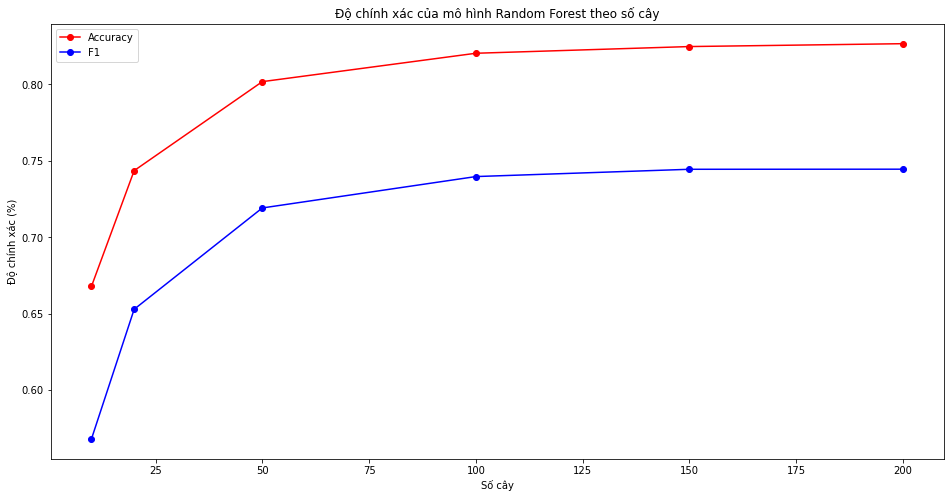

In [33]:
# plot accuracy
plt.figure(figsize=(16, 8))
plt.title('Độ chính xác của mô hình Random Forest theo số cây')
plt.xlabel('Số cây')
plt.ylabel('Độ chính xác (%)')
plt.plot(trees, mean_accuracy_scores, 'ro-')
plt.plot(trees, mean_f1_scores, 'bo-')
plt.legend(['Accuracy', 'F1'], loc='best')
plt.savefig('image/random_forest_accuracy.png', facecolor='whitesmoke')
plt.show()

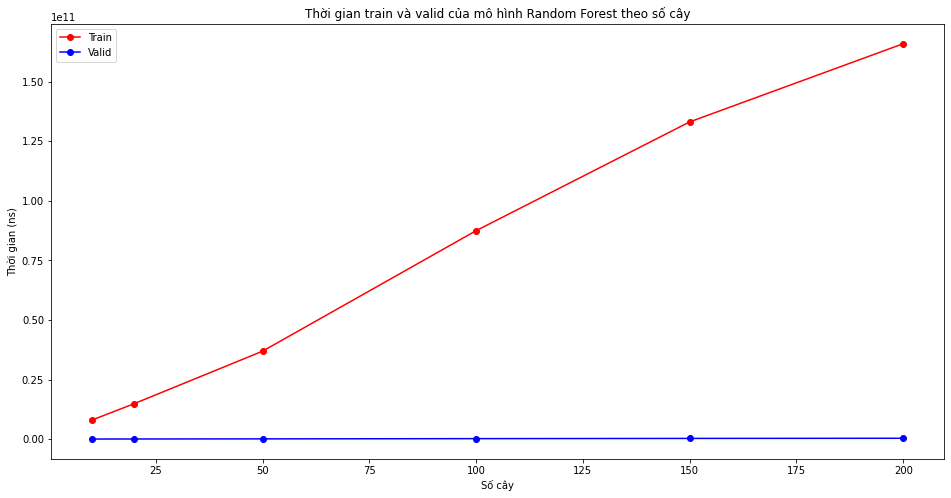

In [34]:
# plot train và valid time
plt.figure(figsize=(16, 8))
plt.title('Thời gian train và valid của mô hình Random Forest theo số cây')
plt.xlabel('Số cây')
plt.ylabel('Thời gian (ns)')
plt.plot(trees, mean_train_time, 'ro-')
plt.plot(trees, mean_valid_time, 'bo-')
plt.legend(['Train', 'Valid'], loc='best')
plt.savefig('image/random_forest_time.png', facecolor='whitesmoke')
plt.show()

**Nhận xét:** Độ chính xác tăng dần theo số cây và có xu thướng bão hòa khi số cây lớn dần và đạt đỉnh tại 200 cây, còn thời gian thì tăng theo hàm tuyết tính với số cây. Để cân bằng giữa độ chính xác và độ hiệu quả, nhóm quyết định chọn số cây là 150.

In [35]:
# Cố định số cây là 150, thay đổi độ đo
criterions = ['entropy', 'gini']

mean_accuracy_scores = []
mean_f1_scores = []
mean_train_time = []
mean_valid_time = []

for criterion in criterions:
    # định nghĩa model
    model = RandomForestClassifier(n_estimators=150, criterion=criterion, random_state=rstate)
    
    accs = []
    f1s = []
    train_times = []
    valid_times = []
    
    for train_index, valid_index in spliter.split(x_train, y_train):    
        # train model
        start = time.time_ns()
        model.fit(train_features[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)
        
        # valid model
        start = time.time_ns()
        y_pred = model.predict(train_features[valid_index])
        valid_times.append(time.time_ns() - start)
        
        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
    print(f'Độ đo = {criterion}:')
    print('\t- Thời gian train: {:.2f} s'.format(mean(train_times) / 1e9))
    print('\t- Thời gian valid: {:.2f} s'.format(mean(valid_times) / 1e9))
    print('\t- Accuracy score:  {:.2f} %'.format(mean(accs) * 100))
    print('\t- F1 score:        {:.2f} %'.format(mean(f1s) * 100))
    
    mean_train_time.append(mean(train_times))
    mean_valid_time.append(mean(valid_times))
    mean_accuracy_scores.append(mean(accs))
    mean_f1_scores.append(mean(f1s))

Độ đo = entropy:
	- Thời gian train: 121.90 s
	- Thời gian valid: 0.31 s
	- Accuracy score:  82.48 %
	- F1 score:        74.45 %
Độ đo = gini:
	- Thời gian train: 101.39 s
	- Thời gian valid: 0.29 s
	- Accuracy score:  85.77 %
	- F1 score:        79.32 %


**Nhận xét:** Độ đo Gini Impurity cho độ chính xác cao hơn cũng như thời gian train ngắn hơn so với độ đo Infomation Gain. Vì vậy, nhóm sẽ chọn độ đo gini cho mô hình Random Forest.

*$\rightarrow$ **Kết luận:**  Vậy tham số tốt nhất cho mô hình Random Forest là 150 cây và độ đo Gini Impurity*

#### 5. Support Vector Machine (SVM)

SVM là một thuật toán học máy rất mạnh chủ yếu được sử dụng cho nhiệm vụ phân loại. Nhiệm vụ của SVM đó là tìm ra ranh giới để chia tách các lớp một các tốt nhất dựa trên các vector hỗ trợ.

Mô hình SVM có 2 siêu tham số để lựa chọn là kernel funtion và độ hiệu chỉnh C.

Danh sách giá trị cho độ hiệu chỉnh C:

$$C \in \{ 0.1, 0.5, 1., 2., 5., 10. \}$$

Danh sách hàm kernel:
- linear: Hàm tuyến tính
- poly: Hàm đa thức
- rbf: Radial Basis Function, đây là hàm được sử dụng nhiều nhất do tính tương tự với phân phối Gaussian
- sigmoid: Hàm sigmoid

In [36]:
# Cố định kernel function mặc định là rbf, thay đổi độ hiệu chỉnh C

Cs = [0.1, 0.5, 1., 2., 5., 10.]

mean_accuracy_scores = []
mean_f1_scores = []
mean_train_time = []
mean_valid_time = []

for c in Cs:
    # định nghĩa model
    model = SVC(C = c)
    
    accs = []
    f1s = []
    train_times = []
    valid_times = []
    
    for train_index, valid_index in spliter.split(x_train, y_train):    
        # train model
        start = time.time_ns()
        model.fit(train_features[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)
        
        # valid model
        start = time.time_ns()
        y_pred = model.predict(train_features[valid_index])
        valid_times.append(time.time_ns() - start)
        
        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
    print(f'Độ hiệu chỉnh C = {c}:')
    print('\t- Thời gian train: {:.2f} s'.format(mean(train_times) / 1e9))
    print('\t- Thời gian valid: {:.2f} s'.format(mean(valid_times) / 1e9))
    print('\t- Accuracy score:  {:.3f} %'.format(mean(accs) * 100))
    print('\t- F1 score:        {:.3f} %'.format(mean(f1s) * 100))
    
    mean_train_time.append(mean(train_times))
    mean_valid_time.append(mean(valid_times))
    mean_accuracy_scores.append(mean(accs))
    mean_f1_scores.append(mean(f1s))

Độ hiệu chỉnh C = 0.1:
	- Thời gian train: 484.16 s
	- Thời gian valid: 31.09 s
	- Accuracy score:  59.972 %
	- F1 score:        43.200 %
Độ hiệu chỉnh C = 0.5:
	- Thời gian train: 340.67 s
	- Thời gian valid: 23.90 s
	- Accuracy score:  86.351 %
	- F1 score:        81.280 %
Độ hiệu chỉnh C = 1.0:
	- Thời gian train: 352.56 s
	- Thời gian valid: 22.19 s
	- Accuracy score:  89.329 %
	- F1 score:        86.080 %
Độ hiệu chỉnh C = 2.0:
	- Thời gian train: 330.20 s
	- Thời gian valid: 21.31 s
	- Accuracy score:  89.850 %
	- F1 score:        86.846 %
Độ hiệu chỉnh C = 5.0:
	- Thời gian train: 354.11 s
	- Thời gian valid: 22.77 s
	- Accuracy score:  89.850 %
	- F1 score:        86.813 %
Độ hiệu chỉnh C = 10.0:
	- Thời gian train: 335.47 s
	- Thời gian valid: 21.50 s
	- Accuracy score:  89.857 %
	- F1 score:        86.826 %


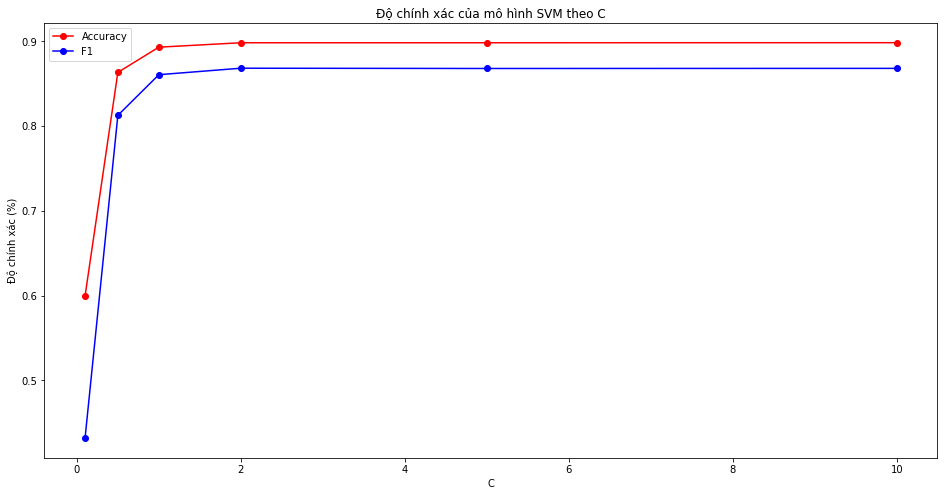

In [37]:
# plot accuracy
plt.figure(figsize=(16, 8))
plt.title('Độ chính xác của mô hình SVM theo C')
plt.xlabel('C')
plt.ylabel('Độ chính xác (%)')
plt.plot(Cs, mean_accuracy_scores, 'ro-')
plt.plot(Cs, mean_f1_scores, 'bo-')
plt.legend(['Accuracy', 'F1'], loc='best')
plt.savefig('image/svm_accuracy.png', facecolor='whitesmoke')
plt.show()

**Nhận xét:** Thời gian train và valid với các hệ số hiệu chỉnh thì gần như nhau, nhưng về độ chính xác thì C = 10.0 cho độ chính xác là cao nhất. Vì vậy, nhóm chọn hệ số hiệu chỉnh tốt nhất cho mô hình SVM là 10.

In [6]:
# Cố định hệ số hiệu chỉnh C = 10.0 và thay đổi kernel function

kernel_functions = ['linear', 'poly', 'rbf', 'sigmoid']

for func in kernel_functions:
    # định nghĩa model
    model = SVC(C = 10.0, kernel=func)
    
    accs = []
    f1s = []
    train_times = []
    valid_times = []
    
    for train_index, valid_index in spliter.split(x_train, y_train):    
        # train model
        start = time.time_ns()
        model.fit(train_features[train_index], y_train[train_index])
        train_times.append(time.time_ns() - start)
        
        # valid model
        start = time.time_ns()
        y_pred = model.predict(train_features[valid_index])
        valid_times.append(time.time_ns() - start)
        
        # evaluate model
        accs.append(accuracy_score(y_train[valid_index], y_pred))
        f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
    print(f'Hàm kernel: {func}')
    print('\t- Thời gian train: {:.2f} s'.format(mean(train_times) / 1e9))
    print('\t- Thời gian valid: {:.2f} s'.format(mean(valid_times) / 1e9))
    print('\t- Accuracy score:  {:.3f} %'.format(mean(accs) * 100))
    print('\t- F1 score:        {:.3f} %'.format(mean(f1s) * 100))

Hàm kernel: linear
	- Thời gian train: 173.80 s
	- Thời gian valid: 38.18 s
	- Accuracy score:  90.720 %
	- F1 score:        88.125 %
Hàm kernel: poly
	- Thời gian train: 534.90 s
	- Thời gian valid: 54.68 s
	- Accuracy score:  64.494 %
	- F1 score:        57.209 %
Hàm kernel: rbf
	- Thời gian train: 330.98 s
	- Thời gian valid: 46.37 s
	- Accuracy score:  89.523 %
	- F1 score:        86.451 %
Hàm kernel: sigmoid
	- Thời gian train: 122.90 s
	- Thời gian valid: 34.19 s
	- Accuracy score:  90.289 %
	- F1 score:        87.591 %


*$\rightarrow$ **Kết luận:** Tham số tốt nhất cho mô hình SVM là hàm linear và hệ số hiệu chỉnh C = 10.*

### So sánh những mô hình tốt nhất

Những mô hình kèm với tham số tốt nhất cho từng mô hình:
- KNN $\rightarrow$ k = 30, khoảng cách Euclide
- Multinomial Naive Bayes $\rightarrow$ alpha = 0.005
- Logistic Regression $\rightarrow$ thuật toán SAGA, L2, C = 16
- Random Forest $\rightarrow$ 150 cây, độ đo gini
- SVM $\rightarrow$ hàm linear, C = 10

Để đánh giá mô hình nào là tốt nhất cho bài toán, nhóm tiến hành train các mô hình này trên tập dữ liệu train và đánh giá trên tập valid như cách lựa chọn tham số cho mô hình.

In [8]:
# Mô hình KNN với K = 30 và sử dụng khoảng cách Euclide
knn = KNeighborsClassifier(n_neighbors=30, metric='euclidean')

# Mô hình Multinomial Naive Bayes với alpha = 0.005
mnb = MultinomialNB(alpha=0.005)

# Mô hình Logistic Regression với thuật toán tối ưu SAGA, phương pháp hiệu chỉnh L2, C = 16
lreg = LogisticRegression(penalty='l2', C=16, solver='saga', max_iter=10_000)

# Mô hình Random Forest với 150 cây và sử dụng độ đo  Gini Impurity
rf = RandomForestClassifier(n_estimators=150, criterion='gini')

# Mô hình SVM sử dụng hàm linear và C = 10
svm = SVC(C=10, kernel='linear')

In [9]:
# Validate mô hình
train_times = []
valid_times = []
accuracy_scores = []
f1_scores = []

In [10]:
# KNN Model
trains = []
valids = []
accs = []
f1s = []

for train_index, valid_index in spliter.split(x_train, y_train):    
    # train model
    start = time.time_ns()
    knn.fit(train_features[train_index], y_train[train_index])
    trains.append(time.time_ns() - start)

    # valid model
    start = time.time_ns()
    y_pred = knn.predict(train_features[valid_index])
    valids.append(time.time_ns() - start)

    # evaluate model
    accs.append(accuracy_score(y_train[valid_index], y_pred))
    f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
# them vao list    
train_times.append(mean(trains))
valid_times.append(mean(valids))
accuracy_scores.append(mean(accs))
f1_scores.append(mean(f1s))

print(f'Mô hình KNN')
print('\t- Thời gian train: {:.2f} s'.format(train_times[-1] / 1e9))
print('\t- Thời gian valid: {:.2f} s'.format(valid_times[-1] / 1e9))
print('\t- Accuracy score:  {:.3f} %'.format(accuracy_scores[-1] * 100))
print('\t- F1 score:        {:.3f} %'.format(f1_scores[-1] * 100))

Mô hình KNN
	- Thời gian train: 0.03 s
	- Thời gian valid: 3.39 s
	- Accuracy score:  83.694 %
	- F1 score:        78.356 %


In [11]:
# Multinomial Naive Bayes Model
trains = []
valids = []
accs = []
f1s = []

for train_index, valid_index in spliter.split(x_train, y_train):    
    # train model
    start = time.time_ns()
    mnb.fit(train_features[train_index], y_train[train_index])
    trains.append(time.time_ns() - start)

    # valid model
    start = time.time_ns()
    y_pred = mnb.predict(train_features[valid_index])
    valids.append(time.time_ns() - start)

    # evaluate model
    accs.append(accuracy_score(y_train[valid_index], y_pred))
    f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
# them vao list    
train_times.append(mean(trains))
valid_times.append(mean(valids))
accuracy_scores.append(mean(accs))
f1_scores.append(mean(f1s))

print(f'Mô hình Multinomial Naive Bayes')
print('\t- Thời gian train: {:.2f} s'.format(train_times[-1] / 1e9))
print('\t- Thời gian valid: {:.2f} s'.format(valid_times[-1] / 1e9))
print('\t- Accuracy score:  {:.3f} %'.format(accuracy_scores[-1] * 100))
print('\t- F1 score:        {:.3f} %'.format(f1_scores[-1] * 100))

Mô hình Multinomial Naive Bayes
	- Thời gian train: 0.17 s
	- Thời gian valid: 0.03 s
	- Accuracy score:  88.877 %
	- F1 score:        86.148 %


In [12]:
# Logistic Regression Model
trains = []
valids = []
accs = []
f1s = []

for train_index, valid_index in spliter.split(x_train, y_train):    
    # train model
    start = time.time_ns()
    lreg.fit(train_features[train_index], y_train[train_index])
    trains.append(time.time_ns() - start)

    # valid model
    start = time.time_ns()
    y_pred = lreg.predict(train_features[valid_index])
    valids.append(time.time_ns() - start)

    # evaluate model
    accs.append(accuracy_score(y_train[valid_index], y_pred))
    f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
# them vao list    
train_times.append(mean(trains))
valid_times.append(mean(valids))
accuracy_scores.append(mean(accs))
f1_scores.append(mean(f1s))

print(f'Mô hình Logistic Regression')
print('\t- Thời gian train: {:.2f} s'.format(train_times[-1] / 1e9))
print('\t- Thời gian valid: {:.2f} s'.format(valid_times[-1] / 1e9))
print('\t- Accuracy score:  {:.3f} %'.format(accuracy_scores[-1] * 100))
print('\t- F1 score:        {:.3f} %'.format(f1_scores[-1] * 100))

Mô hình Logistic Regression
	- Thời gian train: 42.95 s
	- Thời gian valid: 0.03 s
	- Accuracy score:  91.311 %
	- F1 score:        88.773 %


In [13]:
# Random Forest Model
trains = []
valids = []
accs = []
f1s = []

for train_index, valid_index in spliter.split(x_train, y_train):    
    # train model
    start = time.time_ns()
    rf.fit(train_features[train_index], y_train[train_index])
    trains.append(time.time_ns() - start)

    # valid model
    start = time.time_ns()
    y_pred = rf.predict(train_features[valid_index])
    valids.append(time.time_ns() - start)

    # evaluate model
    accs.append(accuracy_score(y_train[valid_index], y_pred))
    f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
# them vao list    
train_times.append(mean(trains))
valid_times.append(mean(valids))
accuracy_scores.append(mean(accs))
f1_scores.append(mean(f1s))

print(f'Mô hình Random Forest')
print('\t - Thời gian train: {:.2f} s'.format(train_times[-1] / 1e9))
print('\t - Thời gian valid: {:.2f} s'.format(valid_times[-1] / 1e9))
print('\t - Accuracy score:  {:.3f} %'.format(accuracy_scores[-1] * 100))
print('\t - F1 score:        {:.3f} %'.format(f1_scores[-1] * 100))

Mô hình Random Forest
	 - Thời gian train: 93.42 s
	 - Thời gian valid: 0.52 s
	 - Accuracy score:  85.343 %
	 - F1 score:        78.854 %


In [14]:
# SVM Model
trains = []
valids = []
accs = []
f1s = []

for train_index, valid_index in spliter.split(x_train, y_train):    
    # train model
    start = time.time_ns()
    svm.fit(train_features[train_index], y_train[train_index])
    trains.append(time.time_ns() - start)

    # valid model
    start = time.time_ns()
    y_pred = svm.predict(train_features[valid_index])
    valids.append(time.time_ns() - start)

    # evaluate model
    accs.append(accuracy_score(y_train[valid_index], y_pred))
    f1s.append(f1_score(y_train[valid_index], y_pred, average='macro'))
    
# them vao list    
train_times.append(mean(trains))
valid_times.append(mean(valids))
accuracy_scores.append(mean(accs))
f1_scores.append(mean(f1s))

print(f'Mô hình SVM')
print('\t- Thời gian train: {:.2f} s'.format(train_times[-1] / 1e9))
print('\t- Thời gian valid: {:.2f} s'.format(valid_times[-1] / 1e9))
print('\t- Accuracy score:  {:.3f} %'.format(accuracy_scores[-1] * 100))
print('\t- F1 score:        {:.3f} %'.format(f1_scores[-1] * 100))

Mô hình SVM
	- Thời gian train: 150.51 s
	- Thời gian valid: 32.85 s
	- Accuracy score:  90.720 %
	- F1 score:        88.125 %


#### Visualize dưới dạng biểu đồ

In [15]:
models = np.array(['KNN', 'Multinomial NB', 'Logistic Regression', 'Random Forest', 'SVM'])

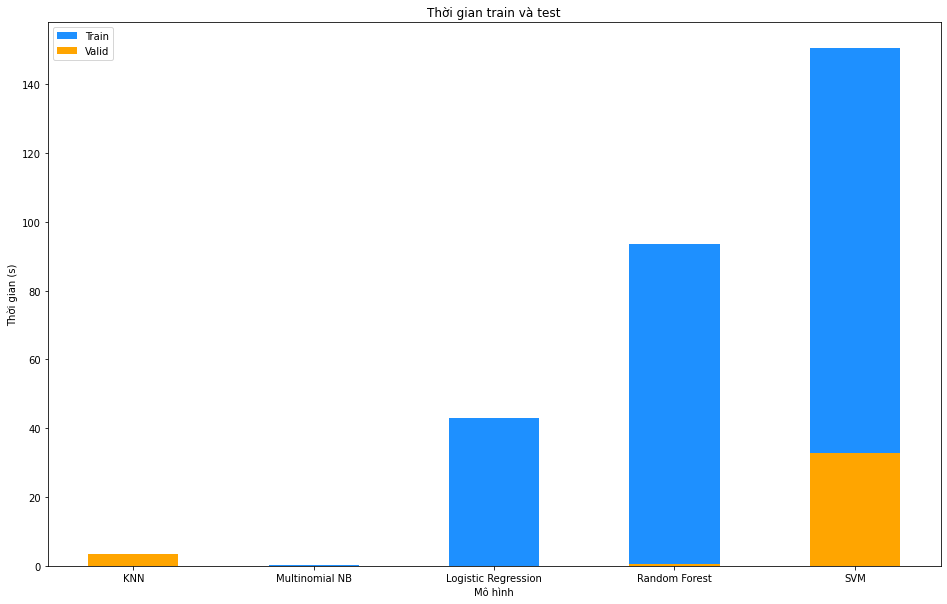

In [17]:
# Về thời gian
plt.figure(figsize=(16, 10))
plt.title('Thời gian train và test')
plt.xlabel('Mô hình')
plt.ylabel('Thời gian (s)')
plt.bar(models, np.array(train_times) / 1e9, color='dodgerblue', width=0.5, label='Train')
plt.bar(models, np.array(valid_times) / 1e9, color='orange', width=0.5, label='Valid')
plt.legend(loc='best')
plt.savefig('image/time_comparision.png', facecolor='whitesmoke')
plt.show()

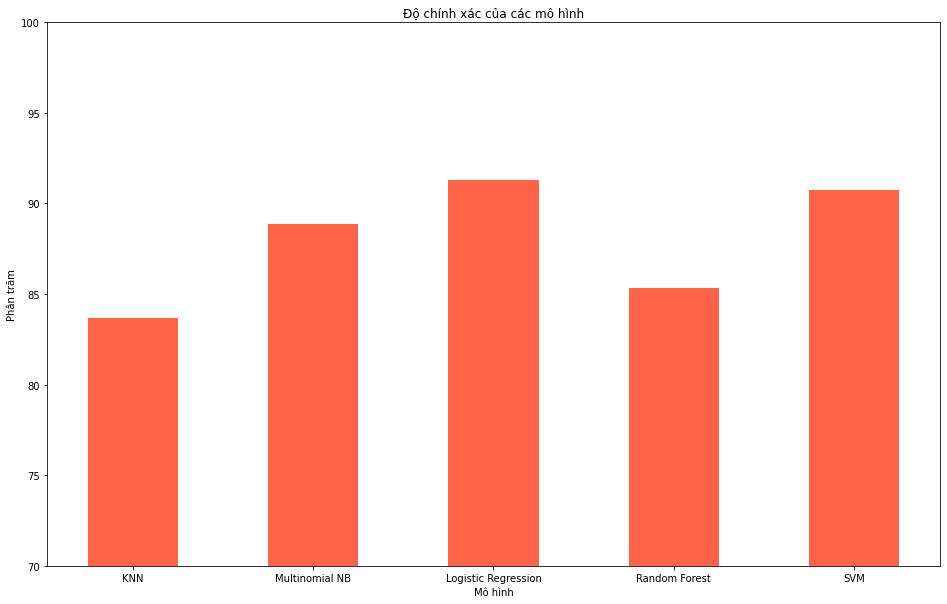

In [18]:
# Về độ chính xác
plt.figure(figsize=(16, 10))
plt.title('Độ chính xác của các mô hình')
plt.xlabel('Mô hình')
plt.ylabel('Phân trăm')
plt.ylim(70, 100)
plt.bar(models, np.array(accuracy_scores) * 100, color='tomato', width=0.5, label='Accuracy')
plt.savefig('image/accuracy_comparision.png', facecolor='whitesmoke')
plt.show()

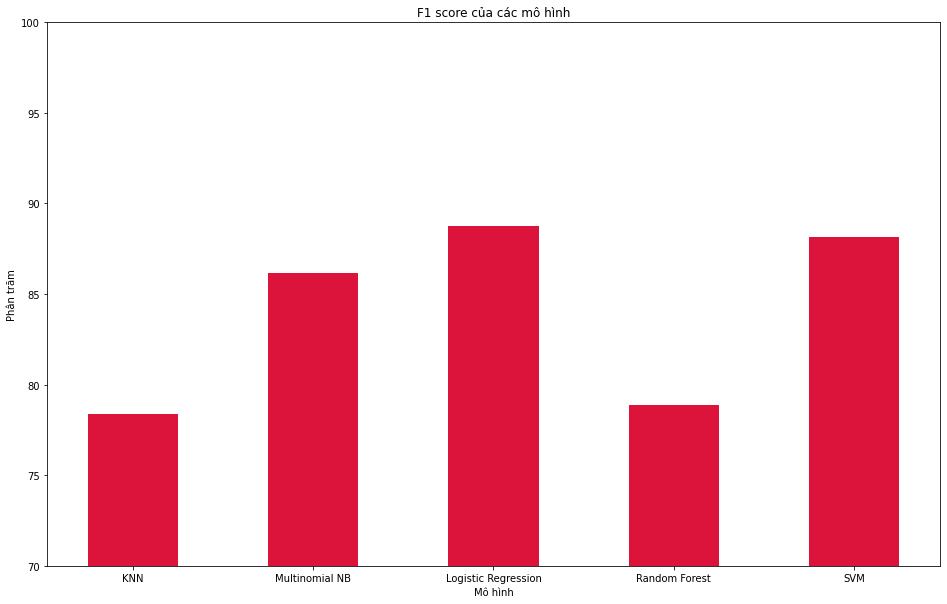

In [19]:
# Về F1 score
plt.figure(figsize=(16, 10))
plt.title('F1 score của các mô hình')
plt.xlabel('Mô hình')
plt.ylabel('Phân trăm')
plt.ylim(70, 100)
plt.bar(models, np.array(f1_scores) * 100, color='crimson', width=0.5, label='F1')
plt.savefig('image/f1_comparision.png', facecolor='whitesmoke')
plt.show()

**Kết luận:** Vậy mô hình được lựa chọn là Logistic Regression với tham số như sau: Thuật toán tối ưu SAGA, hiệu chỉnh L2, C = 16

### Huấn luyện và đánh giá mô hình

#### Huấn luyện

In [20]:
# Đầu tiên, mô hình đã được chọn là Logistic Regression, SAGA, L2, C=16
# Huấn luyện 
start = time.time()
model = LogisticRegression(penalty='l2', C=16, solver='saga', max_iter=10_000, random_state=rstate)
model.fit(train_features, y_train)
print('Huấn luyện xong mô hình sau {:.2f}s'.format(time.time() - start))

Huấn luyện xong mô hình sau 50.84s


#### Đánh giá

In [21]:
# Đánh giá các mô hình trên tập test
# Trích chọn đặc trưng của tập test
test_features = feature_extractor.transform(x_test)

In [22]:
# Đánh giá
y_pred = model.predict(test_features)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy score: {:.3f} %'.format(acc * 100))
print('F1 score:       {:.3f} %'.format(f1 * 100))

Accuracy score: 91.214 %
F1 score:       89.447 %


In [23]:
# report
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

             Am nhac       0.92      0.93      0.93       813
             Am thuc       0.99      0.93      0.96       400
        Bat dong san       0.98      0.95      0.96       282
             Bong da       0.99      1.00      0.99      1464
         Chung khoan       0.98      0.96      0.97       320
              Cum ga       1.00      0.98      0.99       381
    Cuoc song do day       0.67      0.87      0.76       405
              Du hoc       0.98      0.92      0.95       394
             Du lich       0.92      0.95      0.93       565
       Duong vao WTO       0.96      0.82      0.88       191
            Gia dinh       0.86      0.61      0.72       280
    Giai tri tin hoc       0.79      0.91      0.85       707
            Giao duc       0.93      0.92      0.93       707
           Gioi tinh       0.92      0.93      0.92       268
    Hackers va Virus       1.00      0.88      0.94       319
       

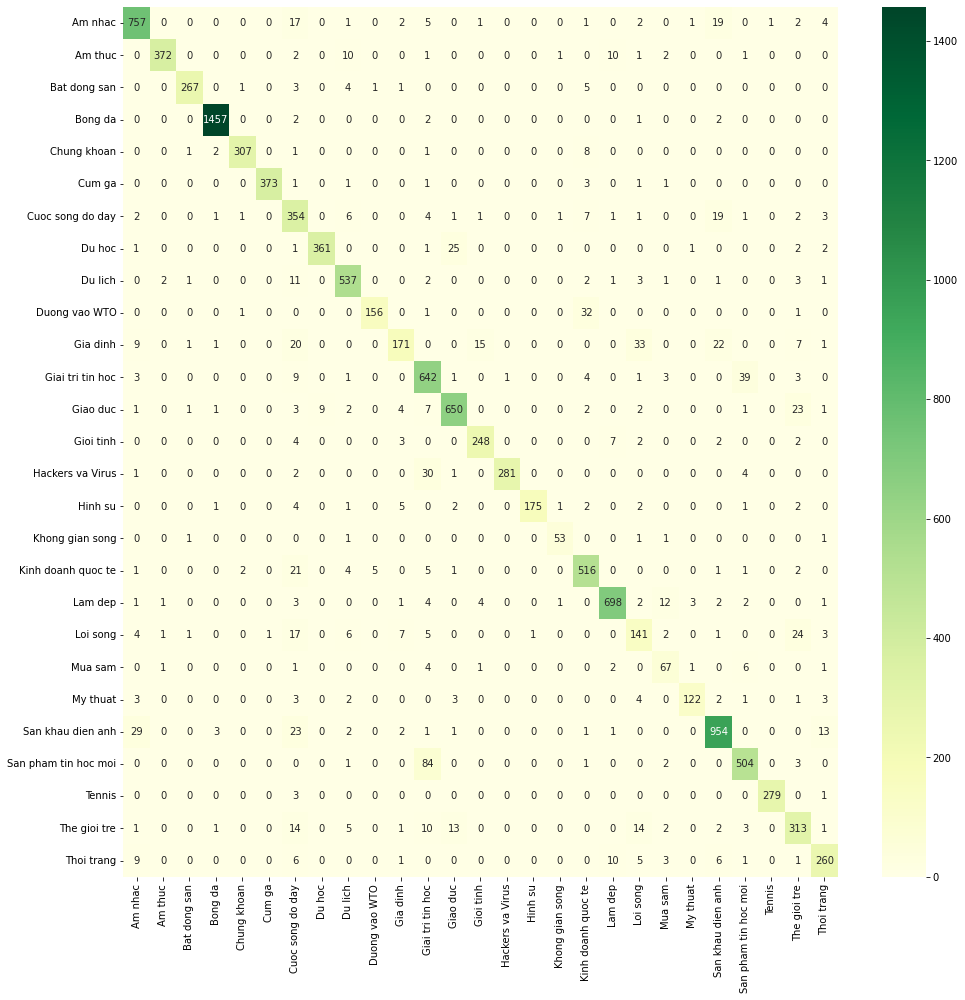

In [27]:
# confuse matrix
import seaborn as sb
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(16, 16))
sb.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlGn' , xticklabels=labels, yticklabels=labels)
plt.savefig('image/conf_matrix.png', facecolor='whitesmoke')

### Kết luận

#### Lưu mô hình

In [28]:
# Lưu mô hình
    
path = 'Data/saved/best_model.sav'
pickle.dump(model, open(path, 'wb'))
print('Lưu mô hình thành công vào địa chỉ {}'.format(path))

Lưu mô hình thành công vào địa chỉ Data/saved/best_model.sav
